<a href="https://colab.research.google.com/github/sushirito/Molecular-Dynamics/blob/main/2D_Pore_Reaction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.7/190.7 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 7.5 MB/s eta 0:00:00


In [ ]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

D = 1.0
k = 0.1
alpha = 1.0

outer = dde.geometry.Rectangle(xmin=[0, 0], xmax=[1, 1])
inclusion = dde.geometry.Disk(center=[0.5, 0.5], radius=0.2)
fluid_domain = outer - inclusion

def robin_func(x, u):
    return k * (alpha - u)

def boundary_solid(x, on_boundary):
    return on_boundary and inclusion.on_boundary(x)

robin_bc = dde.icbc.RobinBC(
    fluid_domain,
    func=robin_func,
    on_boundary=boundary_solid
)


def pde(x, u):
    d2u_dx2 = dde.grad.hessian(u, x, i=0, j=0)
    d2u_dy2 = dde.grad.hessian(u, x, i=1, j=1)
    return D * (d2u_dx2 + d2u_dy2)  # grad^2(u) = 0

data = dde.data.PDE(
    fluid_domain,
    pde,
    [robin_bc],
    num_domain=1000,
    num_boundary=100,
    solution=None,
    num_test=200,
)

net = dde.nn.FNN(
    [2] + [50] * 4 + [1],
    "tanh",
    "Glorot normal",
)

# 5. Model Compilation
model = dde.Model(data, net)
model.compile("adam", lr=0.001)


losshistory, train_state = model.train(
    iterations=10000,
)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

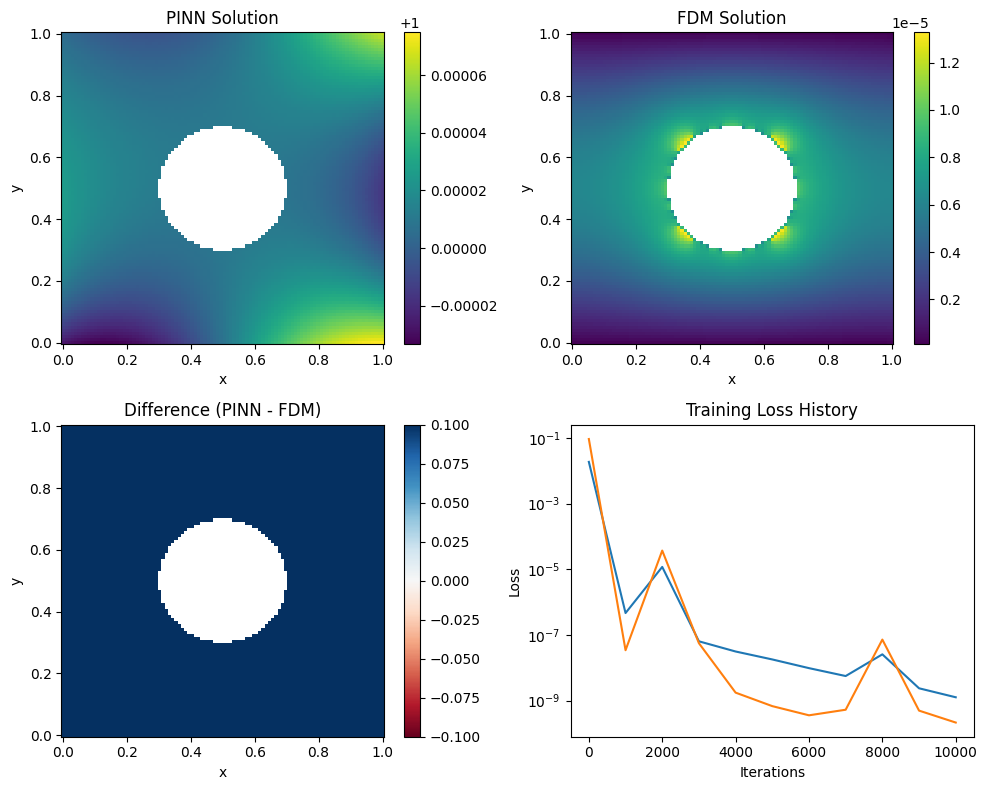

In [11]:
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)
X_flat = X.flatten()[:, None]
Y_flat = Y.flatten()[:, None]
points = np.hstack((X_flat, Y_flat))

Z_pinn = model.predict(points)[:, 0].reshape(X.shape)

mask = (X - 0.5)**2 + (Y - 0.5)**2 <= 0.2**2
Z_pinn[mask] = np.nan

plt.figure(figsize=(10, 8))
plt.subplot(221)
im = plt.pcolormesh(X, Y, Z_pinn, shading='auto', cmap='viridis')
plt.colorbar(im)
plt.title('PINN Solution')
plt.xlabel('x')
plt.ylabel('y')

def fdm_solution(nx, ny, D, k, alpha):
    dx = 1.0 / (nx - 1)
    dy = 1.0 / (ny - 1)

    main_diag = -2 * (1/dx**2 + 1/dy**2) * np.ones(nx*ny)
    off_diag_x = 1/dx**2 * np.ones(nx*ny-1)
    off_diag_y = 1/dy**2 * np.ones(nx*ny-ny)

    A = diags([main_diag, off_diag_x, off_diag_x, off_diag_y, off_diag_y],
              [0, 1, -1, ny, -ny], format='csr')

    b = np.zeros(nx*ny)
    for i in range(nx):
        for j in range(ny):
            idx = i*ny + j
            x, y = i*dx, j*dy
            if (x-0.5)**2 + (y-0.5)**2 <= 0.2**2:
                A[idx, :] = 0
                A[idx, idx] = 1
                b[idx] = 0
            elif (x-0.5)**2 + (y-0.5)**2 <= 0.21**2:  # Boundary approx
                A[idx, idx] -= k/D
                b[idx] = -k*alpha/D

    u = spsolve(A, b)
    return u.reshape((nx, ny))

Z_fdm = fdm_solution(100, 100, D, k, alpha)
Z_fdm[mask] = np.nan

plt.subplot(222)
im = plt.pcolormesh(X, Y, Z_fdm, shading='auto', cmap='viridis')
plt.colorbar(im)
plt.title('FDM Solution')
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(223)
diff = Z_pinn - Z_fdm
im = plt.pcolormesh(X, Y, diff, shading='auto', cmap='RdBu', vmin=-0.1, vmax=0.1)
plt.colorbar(im)
plt.title('Difference (PINN - FDM)')
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(224)
plt.semilogy(losshistory.steps, losshistory.loss_train)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss History')

plt.tight_layout()
plt.show()

Compiling model...
Building feed-forward neural network...
'build' took 0.104065 s

'compile' took 1.074340 s

Training model...

Step      Train loss              Test loss               Test metric
0         [5.64e-02, 2.31e-02]    [5.32e-02, 2.31e-02]    []  
1000      [2.74e-07, 2.96e-08]    [2.30e-07, 2.96e-08]    []  
2000      [8.42e-07, 6.06e-06]    [9.13e-07, 6.06e-06]    []  
3000      [1.61e-08, 2.08e-09]    [1.45e-08, 2.08e-09]    []  
4000      [1.09e-08, 1.29e-09]    [1.01e-08, 1.29e-09]    []  
5000      [7.14e-09, 1.34e-09]    [6.61e-09, 1.34e-09]    []  
6000      [5.53e-09, 7.74e-10]    [5.31e-09, 7.74e-10]    []  
7000      [4.58e-08, 8.30e-08]    [4.14e-08, 8.30e-08]    []  
8000      [2.73e-09, 8.15e-10]    [2.44e-09, 8.15e-10]    []  
9000      [9.86e-10, 3.39e-10]    [8.63e-10, 3.39e-10]    []  
10000     [1.31e-09, 2.98e-10]    [9.60e-10, 2.98e-10]    []  

Best model at step 9000:
  train loss: 1.33e-09
  test loss: 1.20e-09
  test metric: []

'train' took 18.3

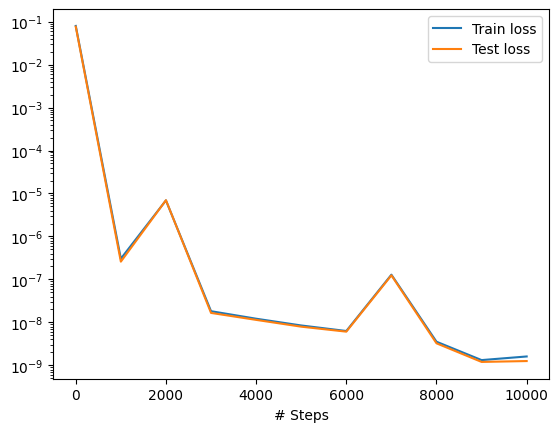

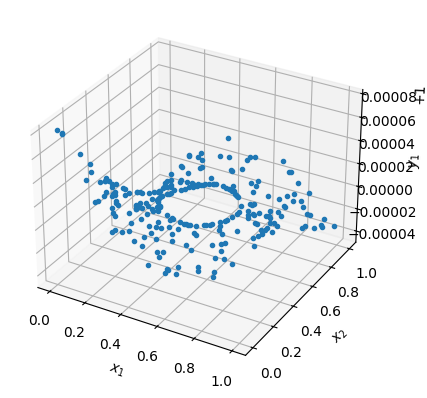

/usr/local/lib/python3.11/dist-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


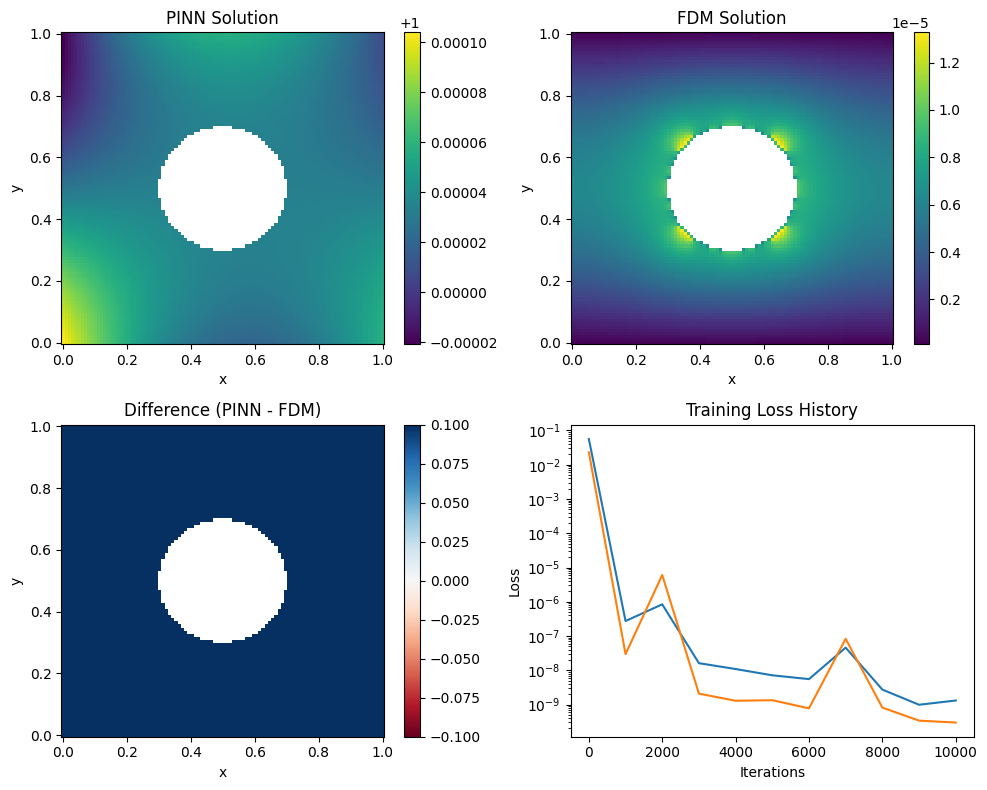

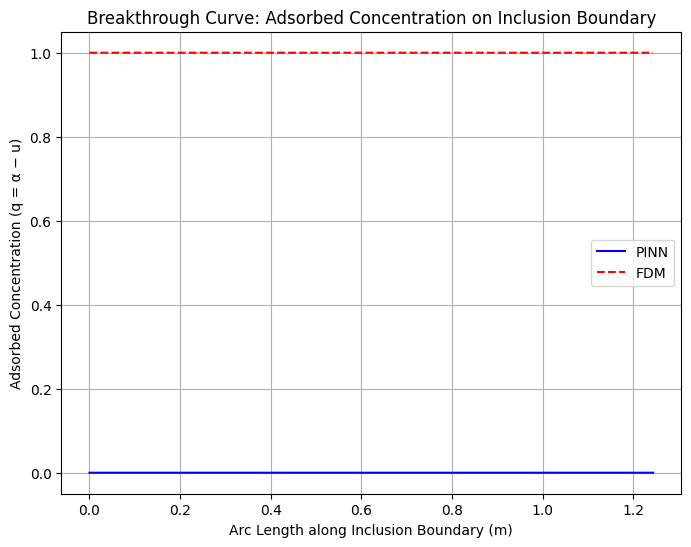

In [47]:
!pip install deepxde

import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from scipy.interpolate import griddata

# Parameters
D = 1.0
k = 0.1
alpha = 1.0

# Geometry: rectangle [0,1]x[0,1] with a circular inclusion
outer = dde.geometry.Rectangle(xmin=[0, 0], xmax=[1, 1])
inclusion = dde.geometry.Disk(center=[0.5, 0.5], radius=0.2)
fluid_domain = outer - inclusion

# Robin BC on the inclusion boundary
def robin_func(x, u):
    return k * (alpha - u)

def boundary_solid(x, on_boundary):
    return on_boundary and inclusion.on_boundary(x)

robin_bc = dde.icbc.RobinBC(fluid_domain, func=robin_func, on_boundary=boundary_solid)

# PDE: Laplace equation
def pde(x, u):
    d2u_dx2 = dde.grad.hessian(u, x, i=0, j=0)
    d2u_dy2 = dde.grad.hessian(u, x, i=1, j=1)
    return D * (d2u_dx2 + d2u_dy2)

data = dde.data.PDE(
    fluid_domain, pde, [robin_bc],
    num_domain=1000, num_boundary=100,
    solution=None, num_test=200,
)

net = dde.nn.FNN([2] + [50]*4 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(iterations=10000)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

# Create grid for visualization
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)
points = np.hstack((X.flatten()[:, None], Y.flatten()[:, None]))

# PINN solution
Z_pinn = model.predict(points)[:, 0].reshape(X.shape)
mask = (X - 0.5)**2 + (Y - 0.5)**2 <= 0.2**2
Z_pinn[mask] = np.nan

# Plot PINN solution
plt.figure(figsize=(10, 8))
plt.subplot(221)
im = plt.pcolormesh(X, Y, Z_pinn, shading='auto', cmap='viridis')
plt.colorbar(im)
plt.title('PINN Solution')
plt.xlabel('x')
plt.ylabel('y')

# FDM solution
def fdm_solution(nx, ny, D, k, alpha):
    dx = 1.0 / (nx - 1)
    dy = 1.0 / (ny - 1)
    main_diag = -2 * (1/dx**2 + 1/dy**2) * np.ones(nx*ny)
    off_diag_x = 1/dx**2 * np.ones(nx*ny-1)
    off_diag_y = 1/dy**2 * np.ones(nx*ny-ny)

    A = diags([main_diag, off_diag_x, off_diag_x, off_diag_y, off_diag_y],
              [0, 1, -1, ny, -ny], format='csr')
    b = np.zeros(nx*ny)
    for i in range(nx):
        for j in range(ny):
            idx = i*ny + j
            xi, yj = i*dx, j*dy
            if (xi-0.5)**2 + (yj-0.5)**2 <= 0.2**2:
                A[idx, :] = 0
                A[idx, idx] = 1
                b[idx] = 0
            elif (xi-0.5)**2 + (yj-0.5)**2 <= 0.21**2:
                A[idx, idx] -= k/D
                b[idx] = -k*alpha/D
    u = spsolve(A, b)
    return u.reshape((nx, ny))

Z_fdm = fdm_solution(100, 100, D, k, alpha)
Z_fdm[mask] = np.nan

plt.subplot(222)
im = plt.pcolormesh(X, Y, Z_fdm, shading='auto', cmap='viridis')
plt.colorbar(im)
plt.title('FDM Solution')
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(223)
diff = Z_pinn - Z_fdm
im = plt.pcolormesh(X, Y, diff, shading='auto', cmap='RdBu', vmin=-0.1, vmax=0.1)
plt.colorbar(im)
plt.title('Difference (PINN - FDM)')
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(224)
plt.semilogy(losshistory.steps, losshistory.loss_train)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.tight_layout()
plt.show()

# Breakthrough Curve: Adsorbed concentration along the inclusion boundary
num_pts = 100
theta = np.linspace(0, 2*np.pi, num_pts, endpoint=False)
x_b = 0.5 + 0.2 * np.cos(theta)
y_b = 0.5 + 0.2 * np.sin(theta)
points_b = np.column_stack((x_b, y_b))

# PINN adsorbed concentration: q = alpha - u
u_pinn_b = model.predict(points_b)[:, 0]
q_pinn = alpha - u_pinn_b

# FDM: interpolate u on the boundary using griddata from valid (non-masked) points
valid = ~mask
pts_valid = np.column_stack((X[valid], Y[valid]))
vals_valid = Z_fdm[valid]
u_fdm_b = griddata(pts_valid, vals_valid, points_b, method='linear')
q_fdm = alpha - u_fdm_b

# Arc length along the circle: s = radius * theta
s = 0.2 * theta

plt.figure(figsize=(8, 6))
plt.plot(s, q_pinn, 'b-', label='PINN')
plt.plot(s, q_fdm, 'r--', label='FDM')
plt.xlabel('Arc Length along Inclusion Boundary (m)')
plt.ylabel('Adsorbed Concentration (q = α − u)')
plt.title('Breakthrough Curve: Adsorbed Concentration on Inclusion Boundary')
plt.legend()
plt.grid(True)
plt.show()


In [49]:
!pip install deepxde

import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# =============================================================================
# Parameters
# =============================================================================
D = 1.0            # diffusivity
k_a = 1.0          # adsorption rate constant (Langmuir)
k_d = 0.1          # desorption rate constant
q_max = 1.0        # maximum adsorbed concentration
T = 0.1            # final time

# =============================================================================
# Geometries
# =============================================================================
# Define time domain
timedomain = dde.geometry.TimeDomain(0, T)

# Outer spatial domain (fluid region plus inclusion area)
outer = dde.geometry.Rectangle(xmin=[0, 0], xmax=[1, 1])
# Inclusion (a circle) on which sorption occurs
inclusion = dde.geometry.Disk(center=[0.5, 0.5], radius=0.2)

# Combined space–time geometry for the outer domain
geom_time = dde.geometry.GeometryXTime(outer, timedomain)
# Space–time geometry for the inclusion (used to sample constraint points)
inclusion_time = dde.geometry.GeometryXTime(inclusion, timedomain)

# =============================================================================
# Define PDE and extra constraints
# Unknown: y(x,y,t) = [u(x,y,t), q(x,y,t)]
# In the fluid (outside the inclusion) we enforce:
#      u_t - D*(u_xx+u_yy)=0.
# (Elsewhere the PDE is “turned off” via an indicator.)
# On the inclusion boundary we add two extra constraints:
#   (i)  Flux:   -D*(du/dn) - q_t = 0.
#   (ii) Kinetics: q_t - [k_a*u*(q_max - q) - k_d*q] = 0.
# Initial conditions: u(x,y,0)=0 (everywhere) and q=0 on the inclusion.
# Also, at the inlet (x=0) we enforce u=1 and no-flux on the other outer boundaries.
# =============================================================================

def pde_u(x, y):
    # Only enforce PDE in the fluid region (i.e. outside the inclusion)
    u = y[:, 0:1]
    u_t = dde.grad.jacobian(y, x, i=0, j=2)
    u_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    u_yy = dde.grad.hessian(y, x, component=0, i=1, j=1)
    # Indicator: 1 for fluid (outside inclusion), 0 inside inclusion
    mask = (((x[:, 0]-0.5)**2 + (x[:, 1]-0.5)**2) > 0.2**2).astype(float)
    return mask * (u_t - D * (u_xx + u_yy))

# Inlet: x = 0, set u = 1.
def inlet(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0)
bc_inlet = dde.DirichletBC(geom_time, lambda x: 1.0, inlet, component=0)

# Outer boundaries (except inlet): Neumann (no flux)
def outer_neumann(x, on_boundary):
    return on_boundary and (not np.isclose(x[0], 0))
bc_neumann = dde.NeumannBC(geom_time, lambda x, y, grad: 0.0, outer_neumann, component=0)

# Initial condition for u on the outer domain: u(x,y,0)=0.
ic_u = dde.IC(geom_time, lambda x: 0.0, lambda x, on_initial: on_initial, component=0)

# Initial condition for q on the inclusion boundary: q(x,y,0)=0.
ic_q = dde.IC(inclusion_time, lambda x: 0.0, lambda x, on_initial: on_initial, component=1)

# Additional constraint on the inclusion boundary: Flux balance.
def flux_constraint(x, y):
    # Compute the normal derivative of u.
    u = y[:, 0:1]
    u_x = dde.grad.jacobian(y, x, i=0, j=0)
    u_y = dde.grad.jacobian(y, x, i=0, j=1)
    # For a circle centered at (0.5,0.5), the outward normal is (x-0.5, y-0.5)/radius.
    nx = (x[:, 0:1] - 0.5) / 0.2
    ny = (x[:, 1:2] - 0.5) / 0.2
    du_dn = u_x * nx + u_y * ny
    q_t = dde.grad.jacobian(y, x, i=1, j=2)
    return -D * du_dn - q_t

# Additional constraint on the inclusion boundary: Langmuir kinetics.
def kinetics_constraint(x, y):
    u = y[:, 0:1]
    q = y[:, 1:2]
    q_t = dde.grad.jacobian(y, x, i=1, j=2)
    return q_t - (k_a * u * (q_max - q) - k_d * q)

# =============================================================================
# Build the data object.
# We use the outer (space–time) geometry for the main PDE and BCs,
# then add extra constraints (including the initial condition for q and the
# two inclusion-boundary residuals) sampled from the inclusion_time geometry.
# =============================================================================
bcs = [ic_u, bc_inlet, bc_neumann]
data = dde.data.TimePDE(geom_time, pde_u, bcs,
                          num_domain=1000,
                          num_boundary=200,
                          num_initial=100)
# Add the extra (inclusion) constraints.
data.add_constraint(ic_q)  # initial condition for q on inclusion
inclusion_points = inclusion_time.uniform_points(200)
bc_flux = dde.PointSetBC(inclusion_points, flux_constraint)
bc_kinetics = dde.PointSetBC(inclusion_points, kinetics_constraint)
data.add_constraint(bc_flux)
data.add_constraint(bc_kinetics)

# =============================================================================
# Define and train the model.
# =============================================================================
net = dde.nn.FNN([3] + [50]*4 + [2], "tanh", "Glorot normal")
model = dde.Model(data, net)
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(iterations=10000)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

# =============================================================================
# Compute breakthrough curve: average q on the inclusion boundary vs time.
# =============================================================================
num_bpts = 100
theta = np.linspace(0, 2*np.pi, num_bpts, endpoint=False)
t_vals = np.linspace(0, T, 50)
q_pinn_avg = []
for t in t_vals:
    x_b = 0.5 + 0.2 * np.cos(theta)
    y_b = 0.5 + 0.2 * np.sin(theta)
    t_b = t * np.ones_like(theta)
    pts = np.stack([x_b, y_b, t_b], axis=1)
    y_pred = model.predict(pts)
    q_vals = y_pred[:, 1]
    q_pinn_avg.append(np.mean(q_vals))
q_pinn_avg = np.array(q_pinn_avg)

plt.figure(figsize=(8, 6))
plt.plot(t_vals, q_pinn_avg, "b-", label="PINN")
plt.xlabel("Time")
plt.ylabel("Average Adsorbed Concentration, q")
plt.title("Breakthrough Curve on the Inclusion Boundary (PINN)")
plt.legend()
plt.grid(True)
plt.show()

# =============================================================================
# FDM solution for comparison (a very simplified explicit scheme)
# =============================================================================
nx, ny = 50, 50
x_grid = np.linspace(0, 1, nx)
y_grid = np.linspace(0, 1, ny)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid)
dx = x_grid[1] - x_grid[0]
dy = y_grid[1] - y_grid[0]
u_fdm = np.zeros((nx, ny))
u_fdm[0, :] = 1.0  # inlet: u = 1 at x = 0

# Mask for fluid (points outside the inclusion)
mask_fluid = ((X_grid - 0.5)**2 + (Y_grid - 0.5)**2 > 0.2**2)

# Sample inclusion boundary (for q)
x_b_sample = 0.5 + 0.2 * np.cos(theta)
y_b_sample = 0.5 + 0.2 * np.sin(theta)
q_fdm = np.zeros(num_bpts)

dt = 0.00005
num_steps = int(T / dt)
t_rec = []
q_fdm_avg_rec = []

for step in range(num_steps):
    t_now = step * dt
    u_new = u_fdm.copy()
    for i in range(1, nx - 1):
        for j in range(1, ny - 1):
            if mask_fluid[i, j]:
                lap = ((u_fdm[i + 1, j] - 2 * u_fdm[i, j] + u_fdm[i - 1, j]) / dx**2 +
                       (u_fdm[i, j + 1] - 2 * u_fdm[i, j] + u_fdm[i, j - 1]) / dy**2)
                u_new[i, j] = u_fdm[i, j] + dt * D * lap
    u_new[0, :] = 1.0
    u_new[-1, :] = u_new[-2, :]
    u_new[:, 0] = u_new[:, 1]
    u_new[:, -1] = u_new[:, -2]
    u_fdm = u_new.copy()

    # Update q on inclusion boundary via Langmuir kinetics.
    pts_grid = np.column_stack((X_grid.flatten(), Y_grid.flatten()))
    u_vals = u_fdm.flatten()
    pts_inc = np.column_stack((x_b_sample, y_b_sample))
    u_at_inc = griddata(pts_grid, u_vals, pts_inc, method="linear")
    u_at_inc = np.where(np.isnan(u_at_inc), 0, u_at_inc)
    flux = k_a * u_at_inc * (q_max - q_fdm) - k_d * q_fdm
    q_fdm = q_fdm + dt * flux

    if step % 100 == 0:
        t_rec.append(t_now)
        q_fdm_avg_rec.append(np.mean(q_fdm))

t_rec = np.array(t_rec)
q_fdm_avg_rec = np.array(q_fdm_avg_rec)

plt.figure(figsize=(8, 6))
plt.plot(t_vals, q_pinn_avg, "b-", label="PINN")
plt.plot(t_rec, q_fdm_avg_rec, "r--", label="FDM")
plt.xlabel("Time")
plt.ylabel("Average Adsorbed Concentration, q")
plt.title("Breakthrough Curve on the Inclusion Boundary")
plt.legend()
plt.grid(True)
plt.show()


AttributeError: 'TimePDE' object has no attribute 'add_constraint'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags, lil_matrix
from scipy.sparse.linalg import spsolve
from scipy.optimize import newton

# Parameters (SI units)
L = 1.0           # Column length [m]
D = 1e-4          # Dispersion coefficient [m²/s]
u = 1e-4          # Interstitial velocity [m/s]
epsilon = 0.35    # Bed porosity [-]
rho_b = 1500      # Bed density [kg/m³]
q_max = 3.5       # Maximum adsorption capacity [mol/kg]
b = 2.0           # Langmuir affinity [m³/mol]
C0 = 1.0          # Inlet concentration [mol/m³]
t_max = 3600*2    # Simulation time [s]

# Numerical parameters
nx = 100          # Spatial nodes
nt = 500          # Temporal nodes
dx = L/(nx-1)
dt = t_max/nt

# Grid setup
x = np.linspace(0, L, nx)
t = np.linspace(0, t_max, nt)
C = np.zeros(nx)  # Initial concentration
C[0] = C0         # Initial inlet condition

# Langmuir isotherm and its derivative
def langmuir(c):
    return (q_max * b * c) / (1 + b * c)

def dlangmuir_dc(c):
    return (q_max * b) / (1 + b * c)**2

# Construct system matrices
main_diag = np.ones(nx)
lower_diag = np.zeros(nx-1)
upper_diag = np.zeros(nx-1)

# Dispersion terms
alpha = D * dt / dx**2
beta = u * dt / (2*dx)

main_diag[1:-1] = 1 + 2*alpha + beta
lower_diag[:] = -alpha + beta
upper_diag[:] = -alpha - beta

# Boundary conditions
main_diag[0] = 1       # Dirichlet (constant concentration)
main_diag[-1] = 1+alpha # Neumann (dc/dx=0 at outlet)
upper_diag[0] = 0
lower_diag[-1] = -2*alpha

A = diags([main_diag, lower_diag, upper_diag], [0, -1, 1], format='lil')

# Newton-Raphson solver for nonlinear system
def residual(c_new):
    q = langmuir(C)
    dq_dc = dlangmuir_dc(C)

    res = np.zeros(nx)
    res[1:-1] = (c_new[1:-1] - C[1:-1])/dt + \
                (1-epsilon)/epsilon * rho_b * (langmuir(c_new[1:-1]) - q[1:-1])/dt - \
                D*(c_new[2:] - 2*c_new[1:-1] + c_new[:-2])/dx**2 + \
                u*(c_new[2:] - c_new[:-2])/(2*dx)

    # Boundary conditions
    res[0] = c_new[0] - C0          # Inlet
    res[-1] = c_new[-1] - c_new[-2] # Outlet (dc/dx=0)
    return res

def jacobian(c_new):
    J = lil_matrix(A.shape)
    J.setdiag(1 + (1-epsilon)/epsilon * rho_b * dlangmuir_dc(c_new)/dt)

    # Dispersion terms
    J.setdiag(-D/dx**2, k=1)
    J.setdiag(-D/dx**2, k=-1)
    J.setdiag(2*D/dx**2 + u/(2*dx), k=0)

    # Boundary conditions
    J[0, 0] = 1
    J[-1, -1] = 1
    J[-1, -2] = -1
    return J

# Time-stepping loop
C_history = np.zeros((nt, nx))
for n in range(1, nt):
    # Solve nonlinear system
    C_guess = C.copy()
    C_new = newton(residual, C_guess, fprime=jacobian, tol=1e-6)

    # Update solution
    C = C_new.copy()
    C_history[n] = C

# Plot breakthrough curve at column outlet
plt.figure(figsize=(12, 6))
plt.plot(t, C_history[:, -1]/C0, 'b-', linewidth=2)
plt.xlabel('Time [s]')
plt.ylabel('C/C₀')
plt.title('Langmuir Isotherm Breakthrough Curve')
plt.grid(True)
plt.show()

In [50]:
!pip install deepxde
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from scipy.optimize import newton

# Parameters
D = 0.1       # Diffusion coefficient
u = 0.05      # Velocity
rho_b = 1600  # Bed density
epsilon = 0.4 # Porosity
q_max = 5.0   # Max adsorption capacity
b = 2.0       # Langmuir coefficient
C0 = 1.0      # Inlet concentration

# Temporal parameters
t_max = 10.0
nt = 100

# Combined geometry (space-time domain)
geom = dde.geometry.Rectangle(xmin=[0, 0], xmax=[1, t_max])
outer = dde.geometry.Rectangle(xmin=[0, 0], xmax=[1, 1])
inclusion = dde.geometry.Disk(center=[0.5, 0.5], radius=0.2)
fluid_domain = outer - inclusion

# Langmuir isotherm functions
def langmuir(c):
    return (q_max * b * c) / (1 + b * c)

def dlangmuir_dc(c):
    return (q_max * b) / (1 + b * c)**2

# Modified PDE with time derivative
def pde(x, c):
    dc_t = dde.grad.jacobian(c, x, i=0, j=1)
    dc_xx = dde.grad.hessian(c, x, i=0, j=0)
    dc_yy = dde.grad.hessian(c, x, i=1, j=1)
    adsorption = (rho_b/epsilon) * dlangmuir_dc(c) * dc_t
    return dc_t - D*(dc_xx + dc_yy) + u*dc_t + adsorption

# Boundary and initial conditions
def boundary_inlet(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0)

def boundary_outlet(x, on_boundary):
    return on_boundary and np.isclose(x[0], 1)

def boundary_time(x, on_initial):
    return on_initial and np.isclose(x[1], 0)

ic = dde.icbc.IC(geom, lambda x: 0, lambda x: boundary_time(x))
bc_inlet = dde.icbc.DirichletBC(geom, lambda x: C0, boundary_inlet)
bc_outlet = dde.icbc.NeumannBC(geom, lambda x: 0, boundary_outlet)

# Define PDE system
data = dde.data.TimePDE(
    geom,
    pde,
    [ic, bc_inlet, bc_outlet],
    num_domain=2000,
    num_boundary=500,
    num_initial=500,
    num_test=1000,
)

# Neural network architecture
net = dde.nn.FNN([2] + [64] * 4 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])

# Training
losshistory, train_state = model.train(iterations=20000, display_every=1000)

# Generate predictions for breakthrough curve
x_outlet = np.hstack((np.ones((nt, 1)), np.linspace(0, t_max, nt)[:, None]))
c_outlet = model.predict(x_outlet)

# Plotting
plt.figure(figsize=(12, 6))

# Breakthrough curve
plt.subplot(121)
plt.plot(x_outlet[:,1], c_outlet, 'b-', linewidth=2)
plt.xlabel('Time')
plt.ylabel('C/C₀')
plt.title('Breakthrough Curve at Outlet')
plt.grid(True)

# Spatial distribution at final time
plt.subplot(122)
x = np.linspace(0, 1, 100)
t_final = np.full((100, 1), t_max)
X = np.hstack((x[:, None], t_final))
C_final = model.predict(X)
plt.plot(x, C_final, 'r-', linewidth=2)
plt.xlabel('Column Length')
plt.ylabel('Concentration')
plt.title('Final Concentration Profile')
plt.grid(True)

plt.tight_layout()
plt.show()


AttributeError: 'Rectangle' object has no attribute 'random_initial_points'